In [23]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from tqdm import tqdm
from PIL import Image
from datetime import datetime
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt


*Note*: There are some other libraries that may be used to further enhance quality of the code. Some of these are, 

1. ipympl: Enables interactive matplotlib plots in jupyter

# Create Synthetic dataset

Synthetic dataset 1

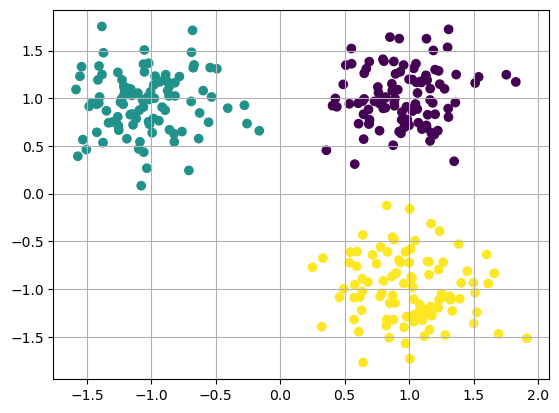

In [4]:
# cluster attributes (means and covariances)
mean1, cov1 = [1,1], [[0.1,0], [0,0.1]]
mean2, cov2 = [-1,1], [[0.1,0], [0,0.1]]
mean3, cov3 = [1, -1], [[0.1, 0], [0, 0.1]]

n = 100 # number of points per cluster

# generate samples
cluster1 = np.random.multivariate_normal(mean1, cov1, n)
cluster2 = np.random.multivariate_normal(mean2, cov2, n)
cluster3 = np.random.multivariate_normal(mean3, cov3, n)

# create dataset by concatenating all the clusters
X = np.vstack([cluster1, cluster2, cluster3]) # input
y = np.array(([0]*n, [1]*n, [2]*n)) # labels
y = y.flatten()

# visualize
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y)
ax.grid(True)
plt.show()

# MLP

In [5]:
class AnotherMLP(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(AnotherMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H),
            nn.Tanh(),  # nn.ReLU()
            nn.Linear(H, D_out)
        )        
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

## Training loop

In [26]:
def which_loss(choice):
    if choice == 1:
        return nn.MSELoss
    elif choice == 2:
        return nn.CrossEntropyLoss

class CustomDataset(Dataset):
    def __init__(self, data, loss_func):
        self.loss_func = loss_func
        X, y = data
        self.X, self.y = self.transforms(X, y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def transforms(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float)
        
        # Convert y to tensor based on specified loss function
        if self.loss_func == str.lower("cross entropy"):
            # For cross entropy loss, y should be of type torch.long (class labels)
            y_tensor = torch.tensor(y, dtype=torch.long)
        elif self.loss_func == str.lower("mse"):
            # For MSE loss, y should be a floating point tensor (continuous values)
            y_tensor = torch.tensor(y, dtype=torch.float)
        else:
            raise ValueError("Unsupported loss function specified.")
        
        return X_tensor, y_tensor
    
def CustomDataloader(dataset, training_portion, batch_size=10):
    size = len(dataset)
    train_size = int(training_portion * size)
    val_size = size - train_size

    train_set, val_set = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, )


def train_loop(dataloader_tr, model, loss_fn, optimizer):
    model.train()

    for batch_idx, data in enumerate(dataloader_tr):
        inputs, labels = data
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # return loss over all batches and number of batches
    return loss.item(), batch_idx+1

def test_loop(dataloader_val, model, loss_fn):
    model.eval()
    
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader_val):
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_fn(outputs, labels).item()
    
    # return loss over all batches and number of batches
    return loss, batch_idx+1

def eval_classification(model, dataloader_val):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in dataloader_val:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())
            correct += (predicted == labels).sum().item()

    # compute metrics
    accuracy = 100 * correct / total
    conf_matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, conf_matrix, f1

In [27]:
# Train and test model
EPOCHS = 100
D_in, H, D_out = 2, 3, 3   
model = AnotherMLP(D_in, H, D_out)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
epoch_mean_loss_tr = []
epoch_mean_loss_v = []

# createDataset
data = (X,y)
dataset = CustomDataset(data, "cross entropy")


for epoch in range(EPOCHS):

    # training
    training_loss, num_batches_tr = train_loop(dataloader_tr=train_loader,
                                               model=model,
                                               loss_fn=criterion,
                                               optimizer=optimizer)
    
    # validation
    validation_loss, num_batches_v = test_loop(dataloader_val=val_loader,
                                               model=model,
                                               loss_fn=criterion)
    
    epoch_mean_loss_tr.append(training_loss/num_batches_tr)
    epoch_mean_loss_v.append(validation_loss/num_batches_v)
 
 # Evaluate model
accuracy, conf_matrix, f1 = eval_classification(model, val_loader)

C:\Users\Zayan\AppData\Local\Temp\ipykernel_20904\3538028592.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float)
C:\Users\Zayan\AppData\Local\Temp\ipykernel_20904\3538028592.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y, dtype=torch.long)


NameError: name 'train_loader' is not defined

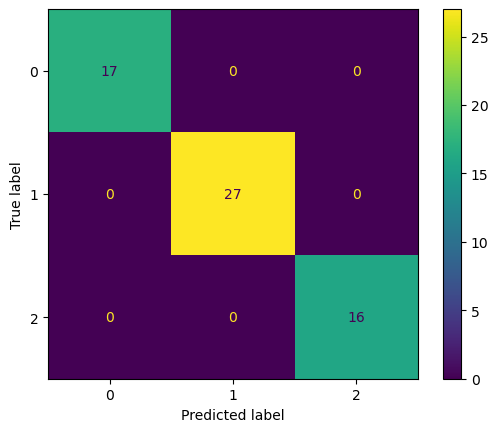

In [17]:
conf_matrix

cm_display = ConfusionMatrixDisplay(conf_matrix).plot()

References

1. https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader
2. https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

## Chatgpt

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, f1_score

# Step 1: Generate a Synthetic Dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Step 2: Create the MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Model instance
model = MLP(input_size=2, hidden_size=50, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the Model
num_epochs = 100
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

# Step 4: Evaluate the Model - Calculate Confusion Matrix and F1 Score
y_pred = []
y_true = []
for inputs, labels in test_loader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.numpy())
    y_true.extend(labels.numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

accuracy, conf_matrix, f1


(100.0,
 array([[63,  0,  0],
        [ 0, 62,  0],
        [ 0,  0, 75]], dtype=int64),
 1.0)

# CNN